<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_3/0_Portfolio_Allocation_Womack_DW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Optimization: Portfolio Allocation

A portfolio is a collection of assets. In a stock portfolio, the investor chooses the stocks, and the dollar value of each, to hold in the portfolio at the start of an investment period. Over this period, the values of the stocks may change. At the end of the period, performance can be measured by the total value of the portfolio. For a given size (or
dollar value) of the portfolio, the key decision is how to allocate the portfolio among its constituent stocks.

The performance of individual stocks can be measured in two ways: **return** and **risk**. Return is the percentage growth in the value of the stock. Risk is the variability associated with the returns on the stock. The information on which stock performance is evaluated is a series of historical returns, typically compiled on a monthly basis. This history provides an empirical distribution of a stock’s return performance. For stock $k$ in the portfolio, this return distribution can be summarized by a mean ($r_k$) and a standard deviation ($s_k$). The performance of a portfolio of stocks is also measured in terms of return and risk. When we create a portfolio of stocks, our goals are usually to maximize the mean return and to minimize the risk. Both goals cannot be met simultaneously, but we can use optimization to explore the trade-offs involved.

**Now...** let's see if we can make some real money here!

See Powell Chapter 8 for more details.
___________________________________________________________________________

In [ ]:
# helpful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
# import datetime # handling dates
# import time # handling times
# from dateutil.relativedelta import relativedelta # time difference
# from matplotlib.pyplot import figure 

In [ ]:
# we need to mount our drive since we are linking to a spreadsheet on our drive!
# copy and paste the code, then enter!
# from google.colab import drive
# drive.mount('/content/drive')

Note that when we bring in Pyomo, we are going to bring in `ipopt` - which is a great nonlinear solver.

More on `ipopt` here: https://coin-or.github.io/Ipopt/

In [ ]:
# install pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' # THIS IS NEW! We are using the IPOPT Solver.
except:
    pass

Suppose we are providing investment advice to Ms. Womack, who has some savings to invest and very clear ideas about her preferred stocks. In fact, she has identified stocks in five different industries
that she believes would constitute a good portfolio. The performance of the five stocks in two recent years is summarized by the means and standard deviations of monthly stock prices, as shown in the
following table:

Stock| Mean| St. Dev.
---|---|---
National Computer| 0.0209| 0.0981
National Chemical| 0.0121| 0.0603
National Power| 0.0069| 0.0364
National Auto| 0.0226| 0.0830
National Electronics| 0.0134| 0.0499

In [ ]:
# read a .csv file of returns
# make sure you navigate to your file and update the path!
# Save the link you were given in a variable
URL = 'https://drive.google.com/file/d/1Nixf7roe8lfi9U514jOrbqrCRDAHW77o/view?usp=sharing'
# You will need the line below to indicate that you will download the content of the link
fixed_path = 'https://drive.google.com/uc?export=download&id='
# Extract the file ID from the URL
file_path = URL.split('/')[-2]

df = pd.read_csv(fixed_path + file_path)
df.head()

,Month,Computer,Chemical,Power,Auto,Electronic
0,1,0.22816,-0.07205,0.01730,0.22266,0.08202
1,2,0.09134,0.02588,0.05646,0.01278,-0.03499
2,3,-0.01288,-0.04771,0.02280,0.00379,0.01662
3,4,-0.17196,0.06342,0.00000,0.04101,-0.07496
4,5,0.16557,0.03670,0.00510,0.07576,-0.00810


In [ ]:
# the data is in order, we don't need the timestamp for now
del df['Month']

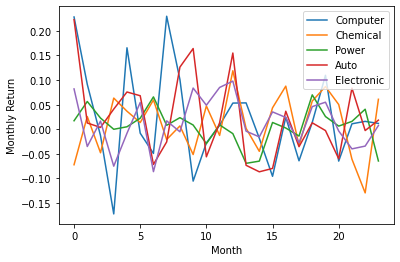

In [ ]:
# see what it looks like... messy... some volatility here!
df.plot()
plt.xlabel('Month')
plt.ylabel('Monthly Return')
plt.show() # get rid of funky text

How do we invest our money so that, overall, we ride out the storm making as much possible in the future (assuming things 'stay the same' in the future)?

We will make a dataframe for the mean of each column in df, and the sd for each column in df.

Notice how some stocks have a high return (computer), but that it also has a high standard deviation! Too much risk might be uncomfortable for an investor...

In [ ]:
Avg_Return = pd.DataFrame(np.mean(df) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(df) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

            Avg_Return
Computer      0.020879
Chemical      0.012055
Power         0.006854
Auto          0.022591
Electronic    0.013353
            Std_Dev_Return
Computer          0.096019
Chemical          0.058993
Power             0.035641
Auto              0.081228
Electronic        0.048877


## Covariance and Modern Portfolio Theory
Read this first: https://www.investopedia.com/articles/financial-theory/11/calculating-covariance.asp

Then read this: https://www.investopedia.com/ask/answers/041315/how-covariance-used-portfolio-theory.asp

A way that we can balance our portfolio is to look at how different stocks vary with each other. 


Remember - covariance is related to correlation - but is not the same thing! Covariance is a numeric representation of how much things vary together. Correlation is covariance divided by standard devation.

In [ ]:
# here's the covariance matrix
Covariance_matrix = df.cov()
Covariance_matrix

,Computer,Chemical,Power,Auto,Electronic
Computer,0.009620,-0.000657,0.000310,0.002690,0.001224
Chemical,-0.000657,0.003631,-0.000043,-0.000576,0.000307
Power,0.000310,-0.000043,0.001326,0.000582,-0.000146
Auto,0.002690,-0.000576,0.000582,0.006885,0.001794
Electronic,0.001224,0.000307,-0.000146,0.001794,0.002493


And here is the correlation matrix.

In [ ]:
Corr_matrix = df.corr()
Corr_matrix

,Computer,Chemical,Power,Auto,Electronic
Computer,1.000000,-0.111138,0.086700,0.330511,0.249862
Chemical,-0.111138,1.000000,-0.019400,-0.115154,0.102110
Power,0.086700,-0.019400,1.000000,0.192502,-0.080412
Auto,0.330511,-0.115154,0.192502,1.000000,0.432995
Electronic,0.249862,0.102110,-0.080412,0.432995,1.000000


But we are only going to use the covariance matrix.

And per your reading, we are looking at including stocks with a negative covariance.

# Build the Nonlinear Optimization Model
This model has a different flavor than other problems you have tackled. 

First, we specify the ConcreteModel. Then we specify our decision variables and BOUND THEM (between 0 and 1) - this is very important for a nonlinear solver so it doesn't go down the rabbit hole!

In [ ]:
# creating covariance table on stock return dataframe
df_cov = df.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = df.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
            Computer  Chemical     Power      Auto  Electronic
Computer    0.009620 -0.000657  0.000310  0.002690    0.001224
Chemical   -0.000657  0.003631 -0.000043 -0.000576    0.000307
Power       0.000310 -0.000043  0.001326  0.000582   -0.000146
Auto        0.002690 -0.000576  0.000582  0.006885    0.001794
Electronic  0.001224  0.000307 -0.000146  0.001794    0.002493


Average Return:
Computer      0.020879
Chemical      0.012055
Power         0.006854
Auto          0.022591
Electronic    0.013353
dtype: float64


In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables
# each one is a stock (Computer, Chemical, Power, Auto, Electronic)
m.Computer = Var(within=NonNegativeReals, bounds=(0,1))
m.Chemical = Var(within=NonNegativeReals, bounds=(0,1))
m.Power = Var(within=NonNegativeReals, bounds=(0,1))
m.Auto = Var(within=NonNegativeReals, bounds=(0,1))
m.Electronic = Var(within=NonNegativeReals, bounds=(0,1))

Now we specify the objective function; **maximize your returns** - make as much money as possible! Note how we are specifying the fraction/proportion we are investing in each stock multiplied by its average return.

We also specify three constriants. 

1.   **The amount you invest in your portfolio** needs to sum to '1' or 100%... you must invest all of your money, regardless of how much money you start with (100K or 100M)
2.   Your returns need to be greater than 0.015 or 1.5%. This is your '**return floor**'.

We will talk about risk in a moment... this will be a third constraint, but it's a little involved.
3. **Your risk must be below a certain level** (your 'risk ceiling'). We will start with 0.0015 (so that you are more likely to make money at low risk... if your risk is high, you will just dump all of your money in one stock - the one that makes the most money on average, but may have high volatility!) RISK for our definition, is simply the covariance matrix TIMES the 'proportion invested'.  The 'proportion invested' is the allocation amount - your decision variable. So, there is a relationship between the risk and the allocation in different stocks.

And as you will see, we will iteratively try to identify which mix of stocks gives us the max return for a given risk level. As the investor, you can choose which risk level makes sense for you - and you can be confident that you are optimally allocating your portfolio for that given risk level.



In [ ]:
# declare objective
m.objective = Objective(expr =               
                        m.Computer*df_return[0] + 
                        m.Chemical*df_return[1] + 
                        m.Power*df_return[2] +
                        m.Auto*df_return[3] + 
                        m.Electronic*df_return[4],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# 1. Sum of all porportions = 1
m.sum_proportions = Constraint(expr = m.Computer + m.Chemical + m.Power + m.Auto + m.Electronic == 1)

# 2. Minimum return should be 0.015 or 1.5%
m.return_floor = Constraint(expr = m.objective >= 0.015)

# 3. Set maximum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below), YOU CAN (and should!) IGNORE IT FOR NOW!
m.total_risk = Constraint(expr = m.Computer + m.Chemical + m.Power + m.Auto + m.Electronic >= 0.0)

Now let's address risk.

What does the following for loop do? Take a look at Excel for guidance.

Remember- risk is just Prop(A)*Prop(B)*Cov(A,B).

It's a square matrix, just like covariance.

Risk = the sum of all values in this intermediate matrix.

In [ ]:
# creating calculations table for calculate the risk
# 3. Max risk should be less than 0.0015
max_risk = 0.0015
def calc_risk():
  # this is a list of all of your investment allocations (proportion invested in each stock)
  # this is UPDATED as the model is cranking - see how we are referncing the decision variables?
  proportions = [ m.Computer, m.Chemical, m.Power, m.Auto, m.Electronic]
  risk_matrix = [] # an empty list
  
  # now we iterate across the covariance matrix
  # 'risk elements' are = cov(A,B)*prop(A)*prop(B)
  # since there are 5 stocks, there are 5*5 = 25 elements
  # sum these 25 elements up at the end! that's the risk.
  # We just need the index, but df_cov.columns gives a list of pairs, so we need to get col as well
  for index, col in enumerate(df_cov.columns):
    i = 0
    risk = []
    for row in df_cov[col]:
      risk.append(proportions[index]*row*proportions[i])
      i = i + 1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() 

# We are going to use this expression to compute the risk
expr_risk = calc_risk()

# Sequence of risk levels
# risk_limits = np.arange(0.001, 0.005, 0.0005) # take tiny steps
risk_limits = np.arange(0.001, 0.01, 0.0005) # take tiny steps
risk_limits

array([0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045,
       0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 , 0.0085,
       0.009 , 0.0095])

# Run the model
Now it's time to run the model!

In [ ]:
# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations 
returns = {} # key=risk, value = return
for r in risk_limits:
  # WE REMOVE AND RECALCULATE THE RISK IN EACH ITERATION
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  # store our allocation proportions
  param_analysis[r] = [m.Computer(), m.Chemical(), m.Power(), m.Auto(), m.Electronic()]
  # store our returns
  returns[r] =  m.Computer()*df_return[0] + m.Chemical()*df_return[1] + m.Power()*df_return[2] + m.Auto()*df_return[3] + m.Electronic()*df_return[4]

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 5
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time:

## Infeasible solutions

Some of our runs may not be feasible, so we want to filter out those cases.

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations 
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue

  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.Computer(), m.Chemical(), m.Power(), m.Auto(), m.Electronic()]
  # store our returns
  returns[r] =  m.Computer()*df_return[0] + m.Chemical()*df_return[1] + m.Power()*df_return[2] + m.Auto()*df_return[3] + m.Electronic()*df_return[4]


    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 5
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.021087169647216797
# -------------------------------

# Parameter Analysis
Let's see what the efficient frontier looks like, and the allocation!

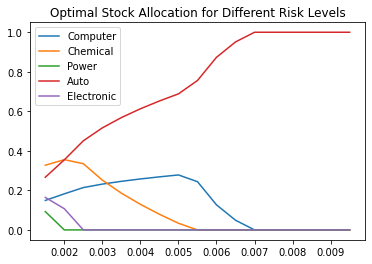

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = [ 'Computer', 'Chemical', 'Power', 'Auto', 'Electronic']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

On the lefthand side, we have low risk and high diversity.

On the righthand side, we have high risk and low diversity (we dump all of our money in the Auto stocks!)

THIS is the beauty of the efficient frontier! Shown below. At each risk level, this is the optimal allocation of stocks. As the investor, you choose what you are comfortable with.

And let's take a look at the efficient frontier - risk (X) vs. return (Y)!

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045000000000000005, 0.005, 0.0055000000000000005, 0.006, 0.0065, 0.007, 0.007500000000000001, 0.008, 0.0085, 0.009000000000000001, 0.009500000000000001]
[0.015908542701542634, 0.017541815600735377, 0.018695821064587014, 0.01954002515707239, 0.02021124745064949, 0.020785707784238522, 0.02129609297519115, 0.021760006301486046, 0.02217301569937081, 0.022373754107787625, 0.022506812543469687, 0.02259082227497462, 0.02259082116332286, 0.022590821145137243, 0.022590821126735078, 0.022590821166237167, 0.02259082113225629]


Plot it!

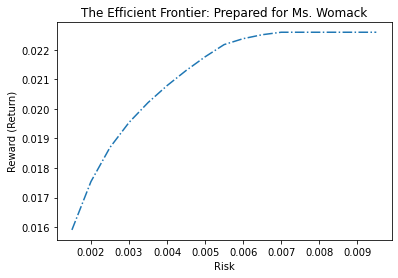

In [ ]:
# plot! pylab makes it easy
from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier: Prepared for Ms. Womack')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

And what do we see? At a certain point, taking on more risk doesn't increase your returns! This occurs at ~Risk = 0.008 which achieves a max return around 2.2% (0.022). Note how this is just the same average return as the Auto stock. This plot also agrees with your allocation plot above - look at 0.008 on the X axis!

Any point on the efficient frontier is an optimal allocation based on your risk tolerance.

Later on, you are going to use this example but with stocks and real-time data. To do this, you'll use the Yahoo Finance API and grab some data. Then you will use pandas to convert this to monthly percentage changes.

Let's see if we can see things 'level off'. Is there a natural inflection point?


In [ ]:
risk = pd.DataFrame(risk)
reward = pd.DataFrame(reward)
reward['risk'] = risk
reward.rename({0:'reward'}, axis=1, inplace=True)
reward['Diff'] = reward['reward'].diff()
reward['percDiff'] = reward['reward'].pct_change()
reward

,reward,risk,Diff,percDiff
0,0.015909,0.0015,NaN,NaN
1,0.017542,0.0020,1.633273e-03,1.026664e-01
2,0.018696,0.0025,1.154005e-03,6.578598e-02
3,0.019540,0.0030,8.442041e-04,4.515469e-02
4,0.020211,0.0035,6.712223e-04,3.435115e-02
5,0.020786,0.0040,5.744603e-04,2.842280e-02
6,0.021296,0.0045,5.103852e-04,2.455462e-02
7,0.021760,0.0050,4.639133e-04,2.178396e-02
8,0.022173,0.0055,4.130094e-04,1.898021e-02
9,0.022374,0.0060,2.007384e-04,9.053275e-03


**On your own:** Try to plot!

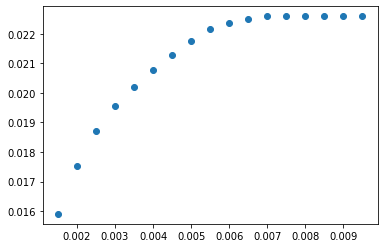

In [ ]:
plt.scatter(x=reward['risk'], y=reward['reward'])
plt.show()

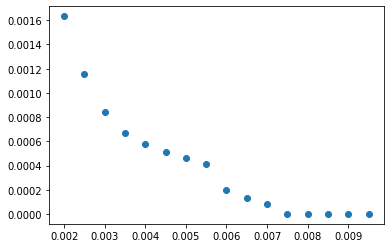

In [ ]:
plt.scatter(x=reward['risk'], y=reward['Diff'])
plt.show()

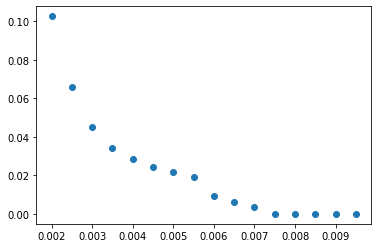

In [ ]:
plt.scatter(x=reward['risk'], y=reward['percDiff'])
plt.show()

# A Note About Risk Levels
Since your risk level is the sum of the covariance*proportion allocated, it can be tough to know what your risk levels are.

You can do this iteratively since the calculations don't take long - first use risk ceilings from 0 to the return floor value. Then look at the graph, find the interesting inflection point, then re-run. This will guarantee success for you. 